In [1]:
%load_ext autoreload
%autoreload 2
import SpectralConvxD as spc
import numpy as np
import tensorflow as tf
import copy 
from typing import Any



In [2]:
x_train, y_train,x_test, y_test=spc.generate_data(name_data='mnist1d')


Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...


In [26]:
maxpooling_config ={'strides': 1,
                     'padding': 'valid' }

hyperparameters = { 'filters' :20,
                    'input_shape' :(40,),
                    'learning_rate' : 0.03,
                    'epochs' : 20,
                    'batch_size' :100,
                    'activation': 'relu',
                    'labels' : 20,
                    'conxd':1,
                    'pool_size':2,
                    'full_training':False,
                    'pre_training': False,
                    }

<unknown>:101: SyntaxWarning: invalid escape sequence '\)'
<unknown>:101: SyntaxWarning: invalid escape sequence '\)'


In [33]:
replication = {'rep':5} 
depth={'N':[2500]}
drop={'p':[0,0.05,0.1,0.15,0.2,0.25, 0.3,0.35, 0.4,0.45, 0.5,0.55, 0.6,0.65, 0.7, 0.75,0.8, 0.85,0.9,0.95,1]}
path =r"C:\Users\jketchak\Documents\DALPHAcommunity\UNAMUR\EUREKA\btwg_ml\SpectralConvxD\SpectralConvxD\DataWarehouse\dtest"
path=spc.utils.remplacer_backslash(path)

In [28]:
# Pre-training weights diag_end
inv=0
models_pars,models_name= spc.pars()
models = spc.SpectralCnn(hyperparameters=hyperparameters,maxpooling_config=maxpooling_config)
models.compile_models(units=2500,spectral_config=models_pars.get(models_name[inv]).get('spectral_config'),
                      spectral_cnn1d_config=models_pars.get(models_name[inv]).get('spectral_cnn1d_config'),
                      spectral_cnn2d_config=models_pars.get(models_name[inv]).get('spectral_cnn2d_config'),
                      name=models_name[inv],
                      layers_name=['convx','spec1','spec2'],
                      layer_cible=None)
models.summary(name=models_name[inv])
for var in models.model.get_layer(name='spec2').variables:
    print(var.name, var.shape)
del models
raise NotImplementedError("This is a test for pre-training weights diag_end")
models.train(x_train, y_train, x_test, y_test, name=models_name[inv],verbose=0)


pre_taining_weights=models.percentile_spectral_filter(trainable_weights=models.model.get_layer(name='spec1').variables,
                                                      name=models_name[inv],
                                                      p=0.9,
                                                      layer_name='spec1')
#get diag_end weights
for k,var in enumerate(pre_taining_weights):
    if var.name=='diag_end':
        inv=0
        diag_end=var.numpy()
        break

#Post-training weights diag_end
del models
models = spc.SpectralCnn(hyperparameters=hyperparameters,maxpooling_config=maxpooling_config)
models.compile_models(units=2500,spectral_config=models_pars.get(models_name[inv]).get('spectral_config'),
                      spectral_cnn1d_config=models_pars.get(models_name[inv]).get('spectral_cnn1d_config'),
                      spectral_cnn2d_config=models_pars.get(models_name[inv]).get('spectral_cnn2d_config'),
                      name=models_name[inv],
                      layers_name=['convx','spec1','spec2'],
                      layer_cible='spec1')

# Set pre-training weights
old_weights=models.model.get_layer(name='spec1').variables
for k,var in enumerate(old_weights):
    if var.name=='diag_end':
        old_weights[k].assign(diag_end)
        break
models.model.get_layer(name='spec1').set_weights(old_weights)
models.summary(name=models_name[inv])

Reference model summary:
 


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convx (SpecCnn1D)               │ (None, 38, 20)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 37, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 740)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spec1 (Spectral)                │ (None, 2500)           │     1,855,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spec2 (Spectral)                │ (None, 20)             │        50,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,905,120 (7.27 MB)

 Trainable params: 1,902,600 (7.26 MB)

 Non-trainable params: 2,520 (9.84 KB)

base (2500, 20)
bias (20,)
diag_end (1, 20)


NotImplementedError: This is a test for pre-training weights diag_end

In [ ]:
models.train(x_train, y_train, x_test, y_test, name=models_name[inv],verbose=1)

In [ ]:
models.evaluate(x_test, y_test, trainable_weights=None, path=path, name=models_name[inv], order=0,layer_name='spec1',p=0.0)

## Pruning model 

In [ ]:
for p in drop.get('p'):
    models.evaluate(x_test, y_test, name=models_name[inv],layers=[3],p=p,order=0,path=path)

In [43]:
results={name : spc.extract_accuracy_and_save(replication=replication,depth=depth,drop=drop,name=name,path=path) for name in ['Full-training','Pre-training','Incoming-connectivity']}


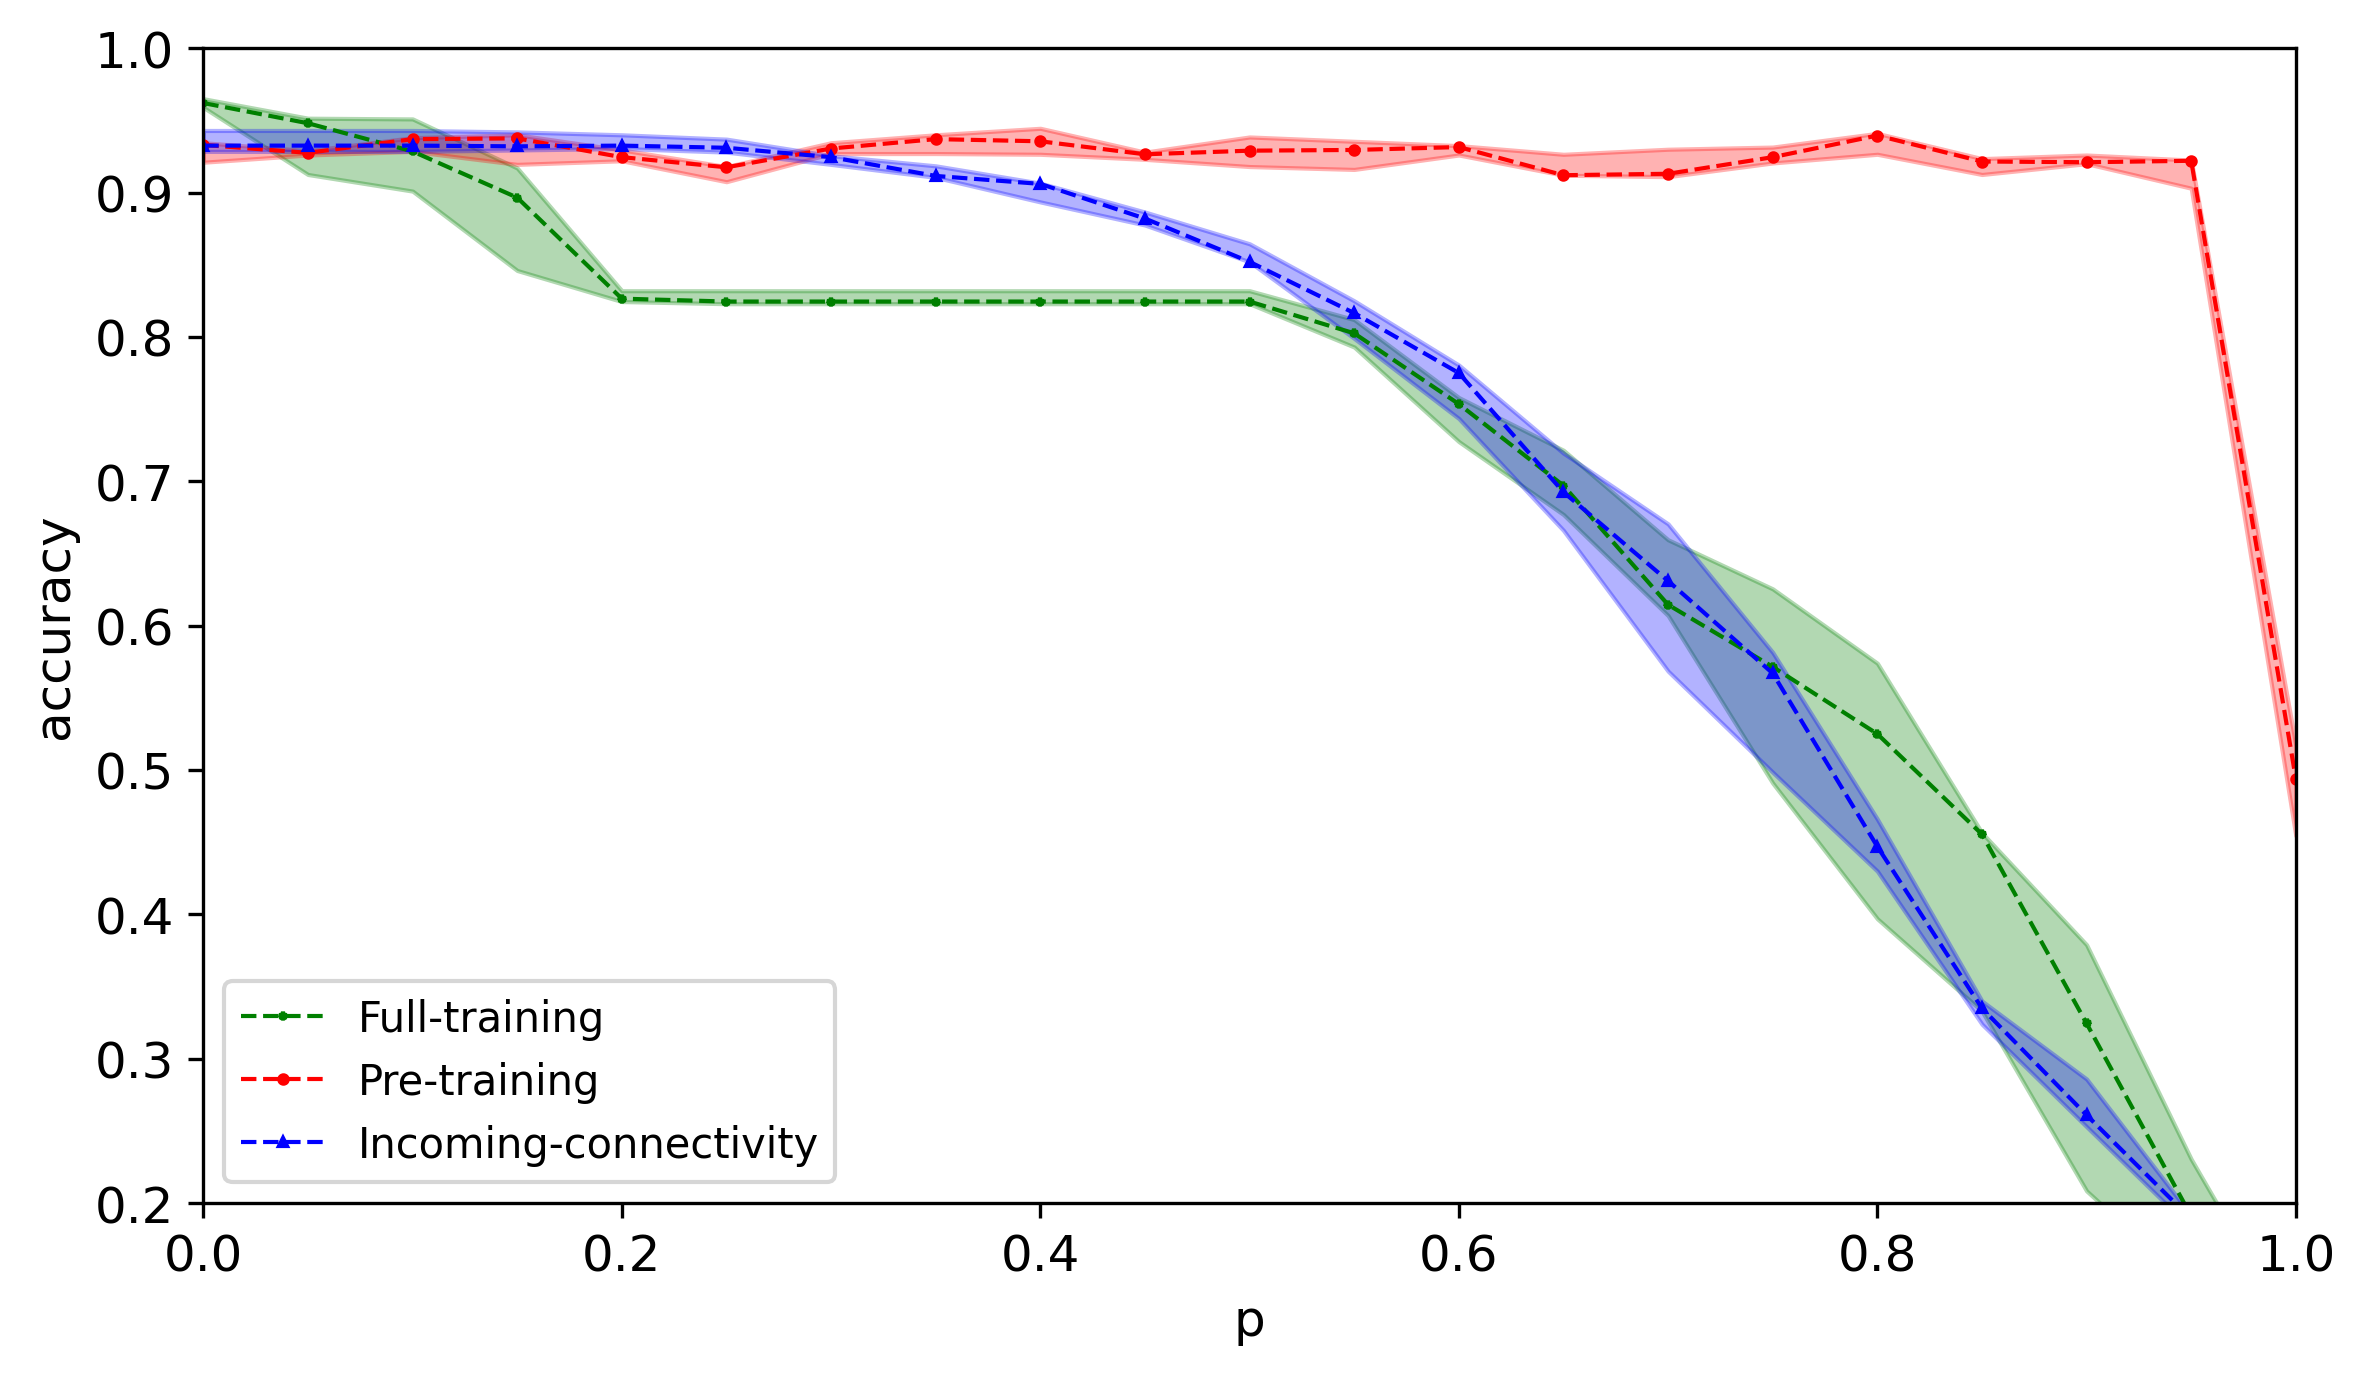

In [45]:
spc.plot_results(results,x_min=0,
            x_max=1,
            y_min=0.2,
            y_max=1.0,
            xlabel='p',
            ylabel='accuracy',
            show_fig=True,
            use_grid=False,
            markersize=2,
            percentile=True,
            save_fig=False,
            dpi=300,
            lw=1,
            alpha=0.3,
            loc='lower left',
            name_fig='results')

## Pre-training

In [ ]:
models_pars.get('specConvXd').get('spectral_cnn1d_config')['trainable_phi']=True
models_pars.get('specConvXd').get('spectral_cnn1d_config')['use_lambda_in']=False

In [ ]:
inv=2
hyperparameters['use_pruning']=False
models_pars.get('specConvXd').get('spectral_cnn1d_config')['trainable_phi']=True
models_pars.get('specConvXd').get('spectral_cnn1d_config')['use_lambda_in']=False
models = spc.SpectralCnn(hyperparameters=hyperparameters,maxpooling_config=maxpooling_config)
models.compile_models(units=2500,spectral_config=models_pars.get(models_name[inv]).get('spectral_config'),
                      spectral_cnn1d_config=models_pars.get(models_name[inv]).get('spectral_cnn1d_config'),
                      spectral_cnn2d_config=models_pars.get(models_name[inv]).get('spectral_cnn2d_config'),
                      name=models_name[inv])
models.summary(name=models_name[inv])
models.train(x_train, y_train, x_test, y_test, name=models_name[inv],verbose=1,layers=[3])

In [ ]:
models.weigths[0][0].shape

In [ ]:
class ReplicateInitializer(tf.keras.initializers.Initializer):
    def __init__(self, base_weights):
        """
        Parameters:
        - base_weights: numpy array or tf.Tensor of shape (m, K)
        """
        if not isinstance(base_weights, (np.ndarray, tf.Tensor)):
            raise ValueError("base_weights must be a numpy array or tf.Tensor")
        self.base_weights = np.array(base_weights, dtype=np.float32)
        self.m, self.K = self.base_weights.shape

    def __call__(self, shape, dtype=None):
        m, n = shape
        if m != self.m:
            raise ValueError(f"Shape mismatch: base_weights has m={self.m}, but target m={m}")
        
        # Réplication en colonnes jusqu'à atteindre n
        repeats = int(np.ceil(n / self.K))
        replicated = np.tile(self.base_weights, (1, repeats))[:, :n]  # coupe à n colonnes
        return tf.convert_to_tensor(replicated, dtype=dtype or tf.float32)

    def get_config(self):
        return {
            "base_weights": self.base_weights.tolist()
        }

In [ ]:
# Poids de base (m=3, K=2)
base_w = np.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

# Création de la couche avec initialisation personnalisée
layer = tf.keras.layers.Dense(
    units=6,  # n = 6
    input_shape=(3,),
    kernel_initializer=ReplicateInitializer(base_w),
    use_bias=False
)

# Vérification
model = tf.keras.Sequential([layer])
model.build((None, 3))
print(model.layers[0].get_weights()[0])